In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from first_glance import report

In [2]:
#Per capita co2 emissions#
#percentage change by year, co2#
#corelation with co2, gdp, population#

In [3]:
# Initial look using first_glance stats_report
report.stats_report('global_co2.csv')

,entry_count,data_type,null_count,mean,std,min,25%,50%,75%,max
country,48058,object,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
year,48058,int64,0,1.926843e+03,5.941485e+01,1750.0,1.883000e+03,1.930000e+03,1.976000e+03,2.022000e+03
population,48058,float64,8563,6.083223e+07,3.285867e+08,222.0,3.464375e+05,2.456362e+06,1.008038e+07,7.975105e+09
gdp,48058,float64,33494,2.677586e+11,2.103151e+12,49980000.0,7.516679e+09,2.597999e+10,1.132942e+11,1.136302e+14
cement_co2,48058,float64,24294,9.109400e+00,6.646355e+01,0.0,0.000000e+00,2.900000e-02,8.340000e-01,1.692404e+03
co2,48058,float64,17750,3.912722e+02,1.855825e+03,0.0,1.830000e-01,3.856000e+00,4.727725e+01,3.714979e+04
coal_co2,48058,float64,22983,1.569639e+02,7.657201e+02,0.0,0.000000e+00,7.030000e-01,1.698800e+01,1.521930e+04
gas_co2,48058,float64,22975,5.127810e+01,3.160338e+02,0.0,0.000000e+00,0.000000e+00,1.344500e+00,7.922112e+03
oil_co2,48058,float64,22947,1.129207e+02,6.294511e+02,0.0,8.400000e-02,1.323000e+00,1.391600e+01,1.237795e+04
share_global_co2,48058,float64,19563,5.163432e+00,1.834465e+01,0.0,2.000000e-03,3.700000e-02,5.180000e-01,1.000000e+02


In [4]:
df = pd.read_csv('global_co2.csv')

In [5]:
# Creating a regex pattern to filter out specific entries from the DataFrame
exclude_list = ['World', 'Europe', 'countries', 'GCP', 'Asia', 'Africa', 'America', 'International']

# Join the list into a single regex pattern
pattern = '|'.join(exclude_list)

# Create a copy of the original DataFrame to work on
co2_df = df.copy()
#co2_df['year'] = pd.to_datetime(co2_df['year'], format='%Y')
# Filter the DataFrame to exclude rows where the 'country' column contains any of the patterns in exclude_list
co2_countries = co2_df[~co2_df['country'].str.contains(pattern, na=False, case=False, regex=True)]

In [6]:
def cumulative_co2(df:pd.DataFrame, direction: str, entry_count: int) -> pd.DataFrame:
    """
    Returns a DataFrame containing the cumulative CO2 emissions for the specified number of countries.

    Parameters:
    direction (str): Specifies whether to return the top or bottom entries by CO2 emissions. Must be either 'top' or 'bottom'.
    entry_count (int): The number of countries to include in the result. Must be a positive integer.

    Returns:
    pd.DataFrame: A DataFrame with the cumulative CO2 emissions for the specified number of countries.

    Raises:
    ValueError: If the 'direction' parameter is not 'top' or 'bottom'.
    ValueError: If the 'entry_count' parameter is not a positive integer.
    """
    # Validate direction parameter
    if direction not in {'top', 'bottom'}:
        raise ValueError('Invalid value for direction. Please select "top" or "bottom".')
    
    # Validate entry_count parameter
    if entry_count <= 0:
        raise ValueError('Entry_count must be a positive integer')

    # Filter out rows with null CO2 values and group by country
    data = df[df['co2'].notnull()].groupby('country').sum()[['co2']]

    # Retrieve the top or bottom entries
    if direction == 'top':
        return data.nlargest(entry_count, 'co2').reset_index()
    elif direction == 'bottom':
        return data.nsmallest(entry_count, 'co2').reset_index()
    
    
def percent_calc(df:pd.DataFrame, calculations:dict):
    for new_col_name, (minor_col, total_col) in calculations.items():
        df[new_col_name] = round(df[minor_col]/ df[total_col]*100, 2)
    return df


def per_capita_creation(df:pd.DataFrame):
    df.loc[:,'co2_per_capita'] = round((df['co2']*1e6) / df['population'],2)
    df[df['co2'].notnull()][['year', 'country', 'co2', 'co2_per_capita']].reset_index(drop=True)
    return df
    
    
def industry_perct_emiss_country(country:'str', df):
    countries = set(df['country'])
    if country not in countries:
        raise ValueError(f'{country} not found in current dataframe')
    return df[(df['country'] == country) & (df['co2'].notnull())][['country', 'year','co2', 'coal_prct', 'oil_prct', 'gas_prct', 'cement_prct']]


def per_cap_by_year(df:pd.DataFrame, direction: str, entry_count: int, year: int) -> pd.DataFrame:
    """
    Returns a DataFrame containing the per capita CO2 emissions for a specified year,
    and the specified number of countries, either top or bottom.

    Parameters:
    direction (str): Specifies whether to return the top or bottom entries by per capita CO2 emissions. Must be either 'top' or 'bottom'.
    entry_count (int): The number of countries to include in the result. Must be a positive integer.
    year (int): The year for which to retrieve the data. Must be less than 2023.

    Returns:
    pd.DataFrame: A DataFrame with the per capita CO2 emissions for the specified number of countries for the given year.

    Raises:
    ValueError: If the 'direction' parameter is not 'top' or 'bottom'.
    ValueError: If the 'entry_count' parameter is not a positive integer.
    ValueError: If the 'year' parameter is not less than 2023.
    """
    # Validate parameters
    if direction not in {'top', 'bottom'}:
        raise ValueError('Invalid value for direction. Please select "top" or "bottom".')
    
    if entry_count <= 0:
        raise ValueError('Entry_count must be a positive integer')
    
    if year >= 2023:
        raise ValueError('Year must be less than 2023')

    # Filter the DataFrame for the specified year and non-null CO2 values
    data = df[(df['year'] == year) & (df['co2'].notnull())]

    # Retrieve the top or bottom entries by per capita CO2 emissions
    if direction == 'top':
        return data.nlargest(entry_count, 'co2_per_capita').reset_index(drop=True)
    elif direction == 'bottom':
        return data.nsmallest(entry_count, 'co2_per_capita').reset_index(drop=True)
    
    
def country_per_cap_co2(df:pd.DataFrame, country: str) -> pd.DataFrame:
    """
    Retrieves the CO2 and per capita CO2 emissions data for a specified country.

    Parameters:
    country (str): The name of the country to retrieve data for. Must be a string.

    Returns:
    pd.DataFrame: A DataFrame containing the CO2 emissions data for the specified country, 
                  including columns for 'country', 'year', 'co2', and 'co2_per_capita'.

    Raises:
    ValueError: If the 'country' parameter is not a string.
    ValueError: If the specified country does not exist within the dataset.
    """
    
    # Check if the country parameter is a string
    if not isinstance(country, str):
        raise ValueError('Country parameter must be a string')
    
    # Create a set of valid country names from the DataFrame
    countries = set(df['country'])
    
    # Check if the specified country exists in the dataset
    if country not in countries:
        raise ValueError(f'Country "{country}" does not exist within the given dataset')
    
    # Filter the DataFrame for the specified country and non-null per capita CO2 values
    data = df[(df['country'] == country) & (df['co2_per_capita'].notnull())]
    
    # Return the relevant columns, resetting the index
    return data[['country', 'year', 'co2', 'co2_per_capita']].reset_index(drop=True)   
    
    
calculations = {'coal_prct': ('coal_co2', 'co2'),
                'oil_prct': ('oil_co2', 'co2'),
                'gas_prct': ('gas_co2', 'co2'),
                'cement_prct': ('cement_co2', 'co2')}


In [7]:
#Cumulative Co2 emissions#
# Top 10 countries ordered by by cumulative co2 
cumulative_co2(co2_countries, 'top', 10)

,country,co2
0,United States,426914.556
1,China,260619.243
2,Russia,119290.814
3,Germany,93985.871
4,United Kingdom,78834.706
5,Japan,67734.911
6,India,59740.694
7,France,39397.693
8,Canada,34613.228
9,Ukraine,30961.508


In [8]:
# Annual co2 emissions
co2_df.groupby('year')[['co2', 'coal_co2', 'oil_co2', 'gas_co2', 'cement_co2']].sum().reset_index()

,year,co2,coal_co2,oil_co2,gas_co2,cement_co2
0,1750,55.836,55.836,0.000,0.000,0.000
1,1751,56.442,56.442,0.000,0.000,0.000
2,1752,57.030,57.030,0.000,0.000,0.000
3,1753,57.660,57.660,0.000,0.000,0.000
4,1754,58.404,58.404,0.000,0.000,0.000
...,...,...,...,...,...,...
268,2018,235455.960,64199.107,53688.346,36409.482,6852.412
269,2019,236804.780,63757.935,54128.837,36884.891,7054.495
270,2020,224973.704,61483.962,48342.117,36501.012,7129.547
271,2021,236484.697,64734.981,50954.326,38299.411,7396.027


In [9]:
# Yearly emissions percentages by industry
yearly_percent_industry = percent_calc(co2_df.groupby('year').sum(), calculations)
yearly_percent_industry.reset_index()[['year', 'co2', 'coal_prct', 'oil_prct', 'gas_prct', 'cement_prct']]

,year,co2,coal_prct,oil_prct,gas_prct,cement_prct
0,1750,55.836,100.00,0.00,0.00,0.00
1,1751,56.442,100.00,0.00,0.00,0.00
2,1752,57.030,100.00,0.00,0.00,0.00
3,1753,57.660,100.00,0.00,0.00,0.00
4,1754,58.404,100.00,0.00,0.00,0.00
...,...,...,...,...,...,...
268,2018,235455.960,27.27,22.80,15.46,2.91
269,2019,236804.780,26.92,22.86,15.58,2.98
270,2020,224973.704,27.33,21.49,16.22,3.17
271,2021,236484.697,27.37,21.55,16.20,3.13


In [10]:
industry_prct_emiss = percent_calc(co2_countries.copy(), calculations)

In [11]:
industry_perct_emiss_country('Canada', industry_prct_emiss)

,country,year,co2,coal_prct,oil_prct,gas_prct,cement_prct
7847,Canada,1785,0.004,100.00,0.00,0.00,NaN
7848,Canada,1786,0.004,100.00,0.00,0.00,NaN
7849,Canada,1787,0.004,100.00,0.00,0.00,NaN
7850,Canada,1788,0.004,100.00,0.00,0.00,NaN
7851,Canada,1789,0.004,100.00,0.00,0.00,NaN
...,...,...,...,...,...,...,...
8080,Canada,2018,577.066,10.57,45.31,39.86,1.21
8081,Canada,2019,578.588,10.13,45.48,40.02,1.24
8082,Canada,2020,522.845,9.28,43.54,42.36,1.28
8083,Canada,2021,537.174,8.54,43.91,42.58,1.37


In [12]:
per_cap_country = per_capita_creation(co2_countries.copy())

In [13]:
# Selecting highest 10 years of co2 per capita in Canada
per_cap_country[(per_cap_country['co2_per_capita'].notnull()) & (per_cap_country['country'] == 'Canada')].nlargest(10, 'co2_per_capita')\
[['country', 'year', 'co2_per_capita']]

,country,year,co2_per_capita
8062,Canada,2000,18.48
8065,Canada,2003,18.39
8041,Canada,1979,18.24
8066,Canada,2004,18.17
8042,Canada,1980,18.07
8069,Canada,2007,18.07
8063,Canada,2001,18.04
8064,Canada,2002,18.02
8061,Canada,1999,17.91
8067,Canada,2005,17.84


In [14]:
per_cap_by_year(per_cap_country, 'top', 15, 2020)

,country,year,population,gdp,cement_co2,co2,coal_co2,gas_co2,oil_co2,share_global_co2,co2_per_capita
0,Qatar,2020,2760390.0,NaN,1.362,102.501,0.000,86.818,12.524,0.293,37.13
1,Bahrain,2020,1477478.0,NaN,0.213,37.396,0.000,33.130,3.609,0.107,25.31
2,Brunei,2020,441736.0,NaN,0.000,11.102,2.132,5.331,3.353,0.032,25.13
3,United Arab Emirates,2020,9287286.0,NaN,5.204,216.768,8.086,132.351,69.331,0.619,23.34
4,Trinidad and Tobago,2020,1518142.0,NaN,0.245,35.030,0.000,30.964,3.444,0.100,23.07
5,Kuwait,2020,4360451.0,NaN,1.187,97.712,0.000,51.688,43.448,0.279,22.41
6,New Caledonia,2020,286412.0,NaN,0.028,5.109,2.714,0.000,2.367,0.015,17.84
7,Saudi Arabia,2020,35997108.0,NaN,25.593,610.773,0.432,261.062,319.430,1.745,16.97
8,Australia,2020,25670052.0,NaN,2.820,396.685,156.681,83.480,135.380,1.133,15.45
9,Sint Maarten (Dutch part),2020,43638.0,NaN,0.000,0.652,0.000,0.000,0.652,0.002,14.94


In [15]:
per_cap_by_year(per_cap_country, 'bottom', 10, 2020)

,country,year,population,gdp,cement_co2,co2,coal_co2,gas_co2,oil_co2,share_global_co2,co2_per_capita
0,Democratic Republic of Congo,2020,92853168.0,NaN,0.498,3.710,0.027,0.000,2.748,0.011,0.04
1,Somalia,2020,16537018.0,NaN,NaN,0.597,0.000,0.000,0.597,0.002,0.04
2,Burundi,2020,12220229.0,NaN,0.003,0.736,0.026,0.000,0.707,0.002,0.06
3,Malawi,2020,19377058.0,NaN,0.240,1.871,0.220,0.000,1.411,0.005,0.10
4,Rwanda,2020,13146367.0,NaN,0.163,1.372,0.011,0.088,1.110,0.004,0.10
5,Niger,2020,24333644.0,NaN,0.032,2.817,0.359,0.073,2.283,0.008,0.12
6,Sierra Leone,2020,8233973.0,NaN,0.000,1.026,0.000,0.000,1.026,0.003,0.12
7,Uganda,2020,44404608.0,NaN,0.559,5.538,0.000,0.000,4.979,0.016,0.12
8,Chad,2020,16644707.0,NaN,0.151,2.279,0.000,0.000,1.847,0.007,0.14
9,Madagascar,2020,28225182.0,NaN,0.058,3.964,1.374,0.000,2.532,0.011,0.14


In [26]:
def country_demo(country:str)->pd.DataFrame:
    """
    Filters and returns a dataframe containing demographic data for a specified country.
    
    This function takes the name of a country as input, validates if the country exists 
    in the dataframe, and filters the `countries_demo` dataframe to include only rows 
    where the 'country' column matches the given country name and the 'population' 
    column is not null. The resulting dataframe is reset to remove the old index 
    and the 'index' column is dropped. If the country does not exist or there is no 
    data for the specified country, a ValueError is raised.

    Parameters:
    country (str): The name of the country to filter the dataframe by.

    Returns:
    pd.DataFrame: A dataframe containing the demographic data for the specified country 
                  with the index reset and 'index' column removed.

    Raises:
    ValueError: If the specified country does not exist in the dataframe or if no data 
                is found for the specified country.
    """
    
    # Validate if the country exists in the dataframe
    countries = set(co2_countries['country'])
    if country not in countries:
        raise ValueError(f'{country} does not exist within given dataframe')

    # Filter the dataframe
    df = co2_countries.loc[(co2_countries['country'] == country) & (co2_countries['population'].notnull())]

    # Check if the filtered dataframe is empty
    if df.empty:
        raise ValueError(f'No data found for {country}')

    # Reset the index and drop the old index column
    df = df[df['co2'].notnull()].reset_index().drop(columns='index')[['country', 'year', 'population', 'gdp', 'co2']]

    return df

In [27]:
china_info = country_demo('China')
canada_info = country_demo('Canada')
us_info = country_demo('United States')
russia_info = country_demo('Russia')

In [28]:
china_info

,country,year,population,gdp,co2
0,China,1907,4.110083e+08,NaN,19.894
1,China,1908,4.132249e+08,NaN,22.736
2,China,1909,4.159058e+08,NaN,24.252
3,China,1910,4.190584e+08,NaN,25.009
4,China,1911,4.226901e+08,3.870341e+11,24.631
...,...,...,...,...,...
111,China,2018,1.417069e+09,1.815162e+13,10353.935
112,China,2019,1.421864e+09,NaN,10721.042
113,China,2020,1.424930e+09,NaN,10914.012
114,China,2021,1.425894e+09,NaN,11336.233


In [29]:
def yearly_prct_chng(df:pd.DataFrame, column_creation:dict, prct_calculations:dict)->pd.DataFrame:
    for new_column, orig_column in column_creation.items():
        df[new_column] = df[orig_column].shift(1)
    for new_column, (current_year, last_year) in prct_calculations.items():
        df[new_column] = round((df[current_year] - df[last_year])/df[current_year]*100, 2)
    return df[['country', 'year', 'population', 'pop_prct_chng', 'gdp', 'gdp_prct_chng','co2', 'co2_prct_chng']]

In [30]:
column_creation = {'last_population': 'population',
                     'last_gdp': 'gdp',
                     'last_co2' : 'co2'}
prct_calculations = {'pop_prct_chng': ('population', 'last_population'),
                     'gdp_prct_chng': ('gdp', 'last_gdp'),
                     'co2_prct_chng': ('co2', 'last_co2')}

In [32]:
canada_demo = yearly_prct_chng(canada_info, column_creation, prct_calculations)

In [53]:
demo_prct_chng = yearly_prct_chng(co2_countries.copy(), column_creation, prct_calculations)

In [58]:
demo_prct_chng[(demo_prct_chng['year'] == 2020) & (demo_prct_chng['country'] == 'United States']

,country,year,population,pop_prct_chng,gdp,gdp_prct_chng,co2,co2_prct_chng
5670,Bhutan,2020,772512.0,0.65,NaN,NaN,0.920,-58.59
24618,Libya,2020,6653946.0,1.28,NaN,NaN,47.068,-49.84
46918,Venezuela,2020,28490458.0,-1.69,NaN,NaN,61.956,-41.41
15567,Fiji,2020,920430.0,0.21,NaN,NaN,1.041,-35.25
4508,Barbados,2020,280704.0,0.18,NaN,NaN,1.234,-35.09
13380,Estonia,2020,1329449.0,0.18,NaN,NaN,9.239,-33.39
24445,Liberia,2020,5087591.0,2.01,NaN,NaN,0.769,-32.64
5397,Bermuda,2020,64051.0,0.34,NaN,NaN,0.458,-29.69
34340,Panama,2020,4294391.0,1.44,NaN,NaN,10.324,-29.61
1235,Andorra,2020,77723.0,1.75,NaN,NaN,0.374,-29.41


In [76]:
corr_df = co2_countries[(co2_countries['population'].notnull()) & (co2_countries['co2'].notnull()) & (co2_countries['gdp'].notnull())]

In [79]:
correlation1 = corr_df['gdp'].corr(corr_df['co2'])
correlation2 = corr_df['population'].corr(corr_df['co2'])

In [80]:
correlation1, correlation2

(0.9229927142539973, 0.5986381087454469)

In [81]:
df = corr_df.corr()

ValueError: could not convert string to float: 'Afghanistan'

<Axes: >

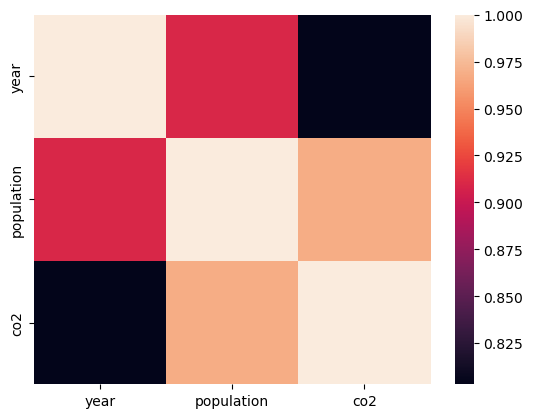

In [52]:
sns.heatmap(df)